## Minimal notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

import seaborn as sns

from collections import Counter
import itertools

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/manuelmorales/miniconda3/envs/training/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import database

In [2]:
# always use False
LOCAL = False

if LOCAL:
    f = open('data/inspire_LA.json','r')
    df = json.load(f)
    f.close()
else:
    r = requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df = r.json()

db_master = pd.DataFrame(df)
db_master.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,H.Albrecht.1,Venezuela,"[{'value': 'hartwig.albrecht@desy.de', 'curren...","Albrecht, Hermann","[{'value': 'H.Albrecht.1', 'schema': 'INSPIRE ...","Unlisted, VE",912061,"{'value': 'Albrecht, Hartwig', 'preferred_name...","[{'recid': 2023395, 'year': '2021', 'citation_...",[{'record': {'$ref': 'https://inspirehep.net/a...,1018731,[]
1,D.M.B.R.1,Venezuela,None,"Bellorin, David","[{'value': 'D.M.B.R.1', 'schema': 'INSPIRE BAI'}]","Unlisted, VE",912061,"{'value': 'R., David M. Bellorin'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023397,[]
2,D.F.Mundarain.1,Chile,None,"Mundarain, Douglas F.","[{'value': 'D.F.Mundarain.1', 'schema': 'INSPI...",Catolica del Norte U.,908143,"{'value': 'Mundarain, Douglas F.'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023398,[]
3,R.Gaitan.2,Venezuela,"[{'value': 'rgaitan@uc.edu.ve', 'current': Fal...","Dominguez, Yessica","[{'value': 'R.Gaitan.2', 'schema': 'INSPIRE BA...","Unlisted, VE",912061,"{'value': 'Gaitan, Rolando', 'preferred_name':...","[{'recid': 1863076, 'year': '2021', 'citation_...","[{'rank': 'PHD', 'record': {'$ref': 'https://i...",1864347,[]
4,J.Ntahompagaze.1,Rwanda,None,"Ntahompagaze, Joseph","[{'value': 'J.Ntahompagaze.1', 'schema': 'INSP...","EAIFR, Kigali",1636656,"{'value': 'Ntahompagaze, Joseph'}","[{'recid': 2087212, 'year': '2022', 'citation_...",None,2087213,[]


# All countries in the database

In [3]:
# find all countries in json
all_countries = db_master['country'].unique()
# get rid of Nonetypes in the database
all_countries = [country for country in all_countries if country is not None]
# sort countries 
all_countries.sort()

print(len(all_countries))

for country in all_countries:
    print(country)
    
# format country 
def format_country(country):
    country = country.lower()
    ans = country.replace(" ", "_")
    return ans

115
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei Darussalam
Bulgaria
Canada
Chile
China
Colombia
Congo
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Holy See (Vatican City State)
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Republic of
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Korea, Republic of
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lithuania
Luxembourg
Madagascar
Malaysia
Malta
Mexico
Moldova
Mongolia
Montenegro
Morocco
Netherlands
New Zealand
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine, State of
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russian Federation
Rwanda
Saudi Arabia
Serbia and Montenegro
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan

# Latin American countries 

In [4]:
# 19 Latin American countries indexed in the database
LA_countries = [
    'Argentina',
    'Bolivia',
    'Brazil',
    'Chile',
    'Colombia',
    'Costa Rica',
    'Cuba',
    'Dominican Republic', # new
    'Ecuador',
    'El Salvador', # new
    'Guatemala',
    'Honduras',
    'Mexico',
    'Panama', # new
    'Paraguay',
    'Peru',
    'Puerto Rico', # new
    'Uruguay',
    'Venezuela'
]

# Jamaica, Bahamas not included. 

LA_countries_format = [format_country(country) for country in LA_countries]
print(LA_countries_format)

['argentina', 'bolivia', 'brazil', 'chile', 'colombia', 'costa_rica', 'cuba', 'dominican_republic', 'ecuador', 'el_salvador', 'guatemala', 'honduras', 'mexico', 'panama', 'paraguay', 'peru', 'puerto_rico', 'uruguay', 'venezuela']


# Combined dataframes of number of papers vs year

In [39]:
def generate_dataframe(country):
    # select column
    db = db_master[db_master['country']==country].reset_index(drop=True)
    
    # obtain list of the institutions of the country
    inst_list = db['institution_id'].drop_duplicates().to_list()
    
    # stack papers and select the ones from the appropriate institutions
    dp = pd.DataFrame(db.papers.apply(pd.Series).stack().to_list()).reset_index(drop=True)
    dp = dp[dp['instituion_id'].isin(inst_list)]
    
    # get rid of paper duplicates
    dp = dp.drop_duplicates(subset='recid')
    
    # skip entries without listed `year`. This ignores the papers that do not have year.
    # For this reason, the sum over all years will not equal the total number of publications
    # from the other notebook. In fact, the result here will be less or equal to it. 
    dp = dp[pd.to_numeric(dp['year'], errors='coerce').notnull()].reset_index(drop=True)
    
    # transform to numerical values
    dp['year'] = pd.to_numeric(dp['year'])
    # get rid of old entries
    dp = dp[dp['year'] >= 1900]
    # get Series
    df_country = dp['year'].value_counts().sort_index()
    df_country = pd.DataFrame({'year': df_country.index, country: df_country.values})
    df_country = df_country.set_index('year')
    
    return df_country


In [41]:
# example
generate_dataframe('Dominican Republic')

,Dominican Republic
year,
1993,2
1994,1
1995,1


In [42]:
# dictionary to store results
df_latam = {}

for country in LA_countries:
    df_latam[country] = generate_dataframe(country)


In [43]:
df_latam['Uruguay']

,Uruguay
year,
1946,1
1969,1
1971,2
1972,3
1974,1
1986,1
1989,5
1990,2
1991,4


In [44]:
# initialise combined dataframe
df_combined = pd.DataFrame(columns=LA_countries)

# TODO: fix the index of the year
# iterate over all latam countries
for country in LA_countries:
    #df_combined[country] = df_latam[country].set_index('year')
    df_combined[country] = df_latam[country]
    
df_combined = df_combined.fillna(0).astype(int)

# add total paperrs
#df_combined['total'] = df_combined.sum(axis=1)

In [45]:
df_combined

,Argentina,Bolivia,Brazil,Chile,Colombia,Costa Rica,Cuba,Dominican Republic,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Panama,Paraguay,Peru,Puerto Rico,Uruguay,Venezuela
year,,,,,,,,,,,,,,,,,,,
1960,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1961,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1966,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1967,5,0,3,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,1
1968,1,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1969,4,1,14,3,0,0,0,0,0,1,0,0,4,0,0,2,0,1,0
1970,7,0,26,9,1,0,0,0,0,0,0,0,5,0,0,1,0,0,2
1971,21,0,30,8,0,0,0,0,0,0,0,0,13,0,0,0,0,2,6
1972,26,0,29,8,0,0,0,0,0,0,0,0,7,0,0,0,0,3,4


In [36]:
df_combined

,Argentina,Bolivia,Brazil,Chile,Colombia,Costa Rica,Cuba,Dominican Republic,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Panama,Paraguay,Peru,Puerto Rico,Uruguay,Venezuela
year,,,,,,,,,,,,,,,,,,,
1960,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,2,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966,1,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,NaN,NaN,1.0
1968,1,3.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1969,4,1.0,14.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,2.0,NaN,1.0,NaN
1970,7,NaN,26.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,2.0
1971,21,NaN,30.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2.0,6.0
1972,26,NaN,29.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3.0,4.0


In [33]:
df_latam['Venezuela'].set_index('year')

,Venezuela
year,
1967,1
1968,1
1970,2
1971,6
1972,4
1973,6
1974,11
1975,10
1976,13


In [34]:
df_combined

,Argentina,Bolivia,Brazil,Chile,Colombia,Costa Rica,Cuba,Dominican Republic,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Panama,Paraguay,Peru,Puerto Rico,Uruguay,Venezuela,total
year,,,,,,,,,,,,,,,,,,,,
1960,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1961,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1966,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1967,5,0,3,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,1,14
1968,1,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10
1969,4,1,14,3,0,0,0,0,0,1,0,0,4,0,0,2,0,1,0,30
1970,7,0,26,9,1,0,0,0,0,0,0,0,5,0,0,1,0,0,2,51
1971,21,0,30,8,0,0,0,0,0,0,0,0,13,0,0,0,0,2,6,80
1972,26,0,29,8,0,0,0,0,0,0,0,0,7,0,0,0,0,3,4,77


In [29]:
df_combined[['total']]

,total
year,
1960,1
1961,5
1966,5
1967,14
1968,10
1969,30
1970,51
1971,80
1972,77


# Load papers of the world

In [11]:
df_world = pd.read_csv('world_papers.csv')
df_world = df_world[['year', 'Citable papers']]

In [12]:
df_world = df_world.set_index('year')

In [13]:
df_world

,Citable papers
year,
1946,49
1947,121
1948,121
1949,137
1950,133
...,...
2019,39620
2020,36144
2021,41154


In [14]:
merged = df_reduced.merge(df_world, on='year', how='right', suffixes=('', '_df_world'))
merged.fillna(0, inplace=True)

In [15]:
merged

,total,Citable papers
year,,
1946,0.0,49
1947,0.0,121
1948,0.0,121
1949,0.0,137
1950,0.0,133
...,...,...
2019,1924.0,39620
2020,2109.0,36144
2021,2459.0,41154


In [16]:
# Calculate percentage
merged['percentage'] = (merged['total'] / merged['Citable papers']) * 100

# Get rid of 2023 and 2022
merged = merged.iloc[:-2]

In [17]:
merged

,total,Citable papers,percentage
year,,,
1946,0.0,49,0.000000
1947,0.0,121,0.000000
1948,0.0,121,0.000000
1949,0.0,137,0.000000
1950,0.0,133,0.000000
...,...,...,...
2017,1966.0,37324,5.267388
2018,1827.0,33026,5.532005
2019,1924.0,39620,4.856133


In [18]:
type(merged)

pandas.core.frame.DataFrame

# Obtain the histogram

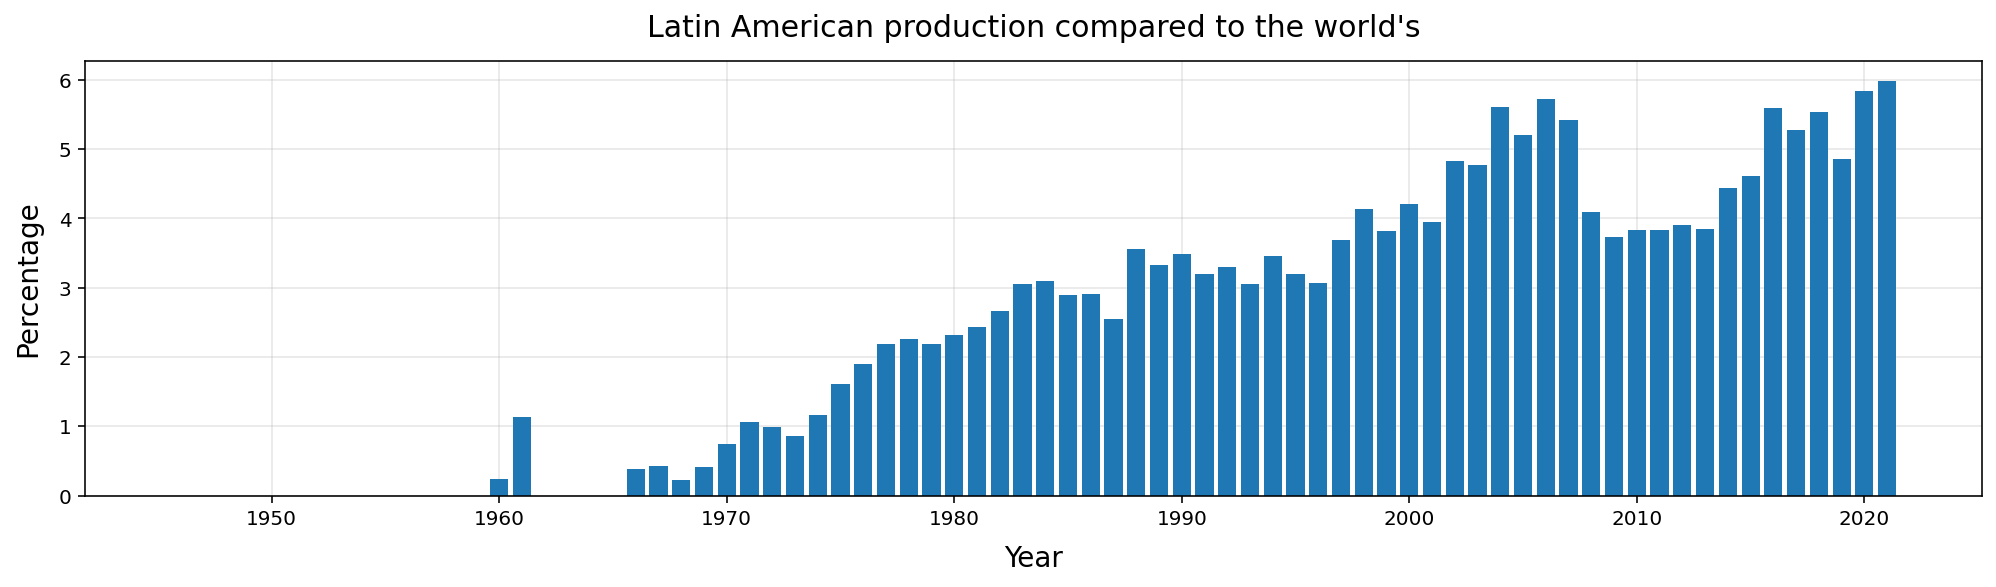

In [19]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17,4))

# Plot the data on the axis
ax.bar(merged.index, merged['percentage'])

# Set the labels and title
ax.set_xlabel('Year', size=14, labelpad=8)
ax.set_ylabel('Percentage', labelpad=8, size=14)
ax.set_title(f"Latin American production compared to the world's", size=15, pad=12)

ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

# Display the plot
plt.show()


In [20]:
# Save the figure as a PDF file
fig.savefig('../figures/world_comparison/papers_world_comparison.pdf', bbox_inches='tight')